# Random Forest
Haytham Mohamed

INFS 890 - Spring 2020

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [13]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

#data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


SCALE_TARGETS = True

test_split = 0.1

In [14]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [15]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
0,0.0300,0.0100,0.0100,0.0100,0.0100,0.0100,0.0100,0.0300,0.0700,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.5000,0.1500,0.9311
1,0.0600,0.0200,0.0200,0.0200,0.0200,0.0100,0.0100,0.1800,0.1800,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.8900,0.1500,0.9311
2,0.0700,0.0300,0.0200,0.0300,0.0200,0.0100,0.0100,0.4400,0.2000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.3500,0.1500,0.9311
3,0.0700,0.0300,0.0200,0.0200,0.0200,0.0100,0.0100,0.2300,0.1700,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.2600,0.1300,0.9311
4,0.0700,0.0200,0.0100,0.0200,0.0200,0.0100,0.0100,0.2400,0.1400,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.2800,0.3600,0.9311


In [16]:
data.shape

(3290, 18)

In [17]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))


there are 17 features


In [18]:
# scale targets for better convergence
if SCALE_TARGETS:
    y_scaler =  MinMaxScaler()
    targets = y_scaler.fit_transform(targets.values.reshape(-1,1))

In [19]:
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

if 1 == 0:
    # for better convergence and result scale target to values between 0 - 1
    y_train_max = y_train.max()
    y_test_max = y_test.max()

    y_train = y_train / y_train_max
    y_test = y_test / y_test_max


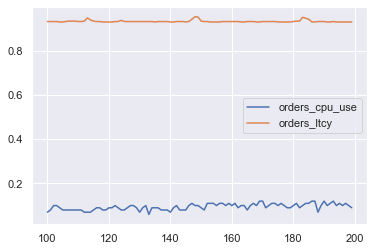

In [20]:
# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][100:200], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][100:200], label='orders_ltcy')
plt.legend()
plt.show()

#ax = sns.regplot(x=data['orders_cpu_use'], y=data['orders_ltcy'], color='g')


# Model

In [21]:
#lasso = LassoCV(fit_intercept=False,n_jobs=-1,random_state=0,selection='random',positive=False,cv=10)
#sfm1 = SelectFromModel(lasso, threshold='0.01*mean')

rfr = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=20)
sfm = SelectFromModel(rfr, threshold='0.01*mean')

#sfm = SelectKBest(k=6)

#sfm = PCA(random_state=180)

reg = RandomForestRegressor()

pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', sfm),
    ('reg', reg)
])

kfold = KFold(n_splits=10, shuffle=True)

param_grid = {
    #'selector__threshold': [0.1, 0.05, 0.02, 0.001]  # with lasso
    'selector__threshold': ['0.8*mean', '0.6*mean', '0.3*mean', '0.1*mean','0.05*mean', '0.02*mean', '0.01*mean', '0.001*mean'] # with tree
    , 'selector__estimator__max_depth' : [10, 15]
    , 'selector__estimator__n_estimators' : [20, 30, 40]
    # 'selector__n_components' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]   # with PCA
    , 'reg__max_features': [13, 11, 9]   # The maximum number of features to consider
    , 'reg__n_estimators': [10, 8, 6]  # The number of trees in the forest 
}

search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=1, n_jobs=-1)

#scores = cross_val_score(pipe, x_train, y_train, cv=kfold, n_jobs=-1
        #, verbose=3, scoring='neg_mean_squared_error')



In [22]:
import sklearn 
print('sklearn version {}'.format(sklearn.__version__))

search.fit(x_train, y_train)

sklearn version 0.22.2.post1
Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  6.6min finished
/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **f

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selector',
                                        SelectFromModel(estimator=RandomForestRegressor(bootstrap=True,
                                                                                        ccp_alpha=0.0,
                                                                                        criterion='mse',
                                                                                        max_depth=10,
                                                                                        max_features='auto',
                      

# Best Model

In [23]:
score = search.best_score_
print("Best CV test score = %0.4f:" % score)

params = search.best_params_
print("Best CV params = {}".format(params))

#print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")

#print('mean train scores')
#print(all_training_scores['mean_train_score'])

#print('mean test scores')
#print(all_training_scores['mean_test_score'])


Best CV test score = -0.0063:
Best CV params = {'reg__max_features': 11, 'reg__n_estimators': 10, 'selector__estimator__max_depth': 10, 'selector__estimator__n_estimators': 30, 'selector__threshold': '0.001*mean'}


# Features Selected

In [24]:
if 1 == 0:
    best_threshold = params['selector__threshold']
    best_max_depth = params['selector__estimator__max_depth']
    best_n_estimators = params['selector__estimator__n_estimators']

    select_model = RandomForestRegressor(n_jobs=-1, max_depth=best_max_depth, n_estimators=best_n_estimators)
    sfm = SelectFromModel(model, threshold=best_threshold)

    selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

    feature_list = x_train.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    #features

    reduced_x_train = x_train[feature_list]
    #reduced_x_train.head(2)
    print('')
    for feature in reduced_x_train.columns.values:
        print(feature)

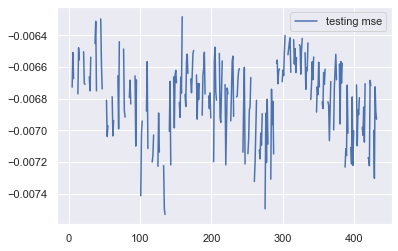

In [25]:
pdf = pd.DataFrame(all_training_scores['mean_test_score'], columns=['testing mse'])
pdf.plot()

# Training R2

In [26]:
y_train_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_train_hat)
print('R2 (training) = {}'.format(r2_train))

print('Score (training) = {}'.format(search.score(x_train,y_train)))

R2 (training) = 0.9470556384888075
Score (training) = -0.0010240297294310085


In [27]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_train_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.13 (0.13) 0.00 0.96 MSE


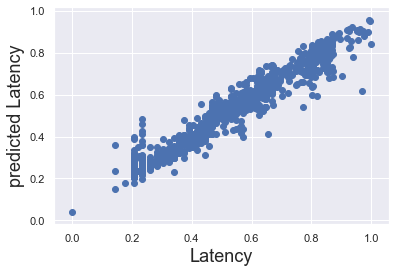

In [28]:
plt.scatter(y_train, y_train_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

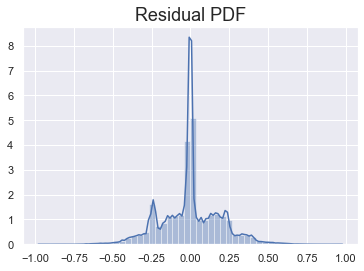

In [29]:
sns.distplot(y_train - y_train_hat)
plt.title('Residual PDF', size=18)

# Testing

In [30]:
y_test_hat = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

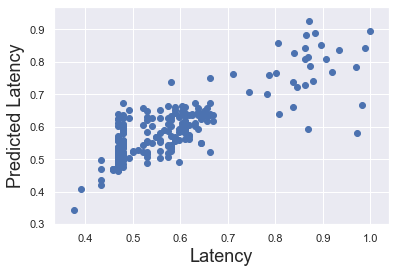

In [31]:
plt.scatter(y_test, y_test_hat)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

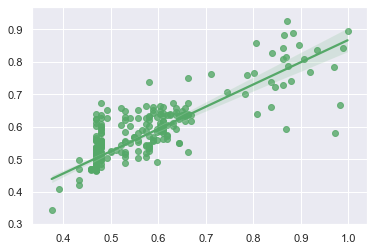

In [32]:
ax = sns.regplot(x=y_test, y=y_test_hat, color='g')

In [33]:
perf = pd.DataFrame(y_test_hat, columns=['prediction'])
perf['target'] = y_test
perf.head()

,prediction,target
0,0.4734,0.4689
1,0.5239,0.5013
2,0.5690,0.5482
3,0.6059,0.5210
4,0.6031,0.4801


In [34]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,0.4734,0.4689,0.0044,0.9441
1,0.5239,0.5013,0.0226,4.5079
2,0.5690,0.5482,0.0208,3.7886
3,0.6059,0.5210,0.0849,16.3027
4,0.6031,0.4801,0.1230,25.6166
...,...,...,...,...
324,0.4972,0.4325,0.0647,14.9477
325,0.4095,0.3908,0.0187,4.7852
326,0.4345,0.4325,0.0020,0.4666
327,0.4191,0.4325,-0.0135,3.1101


In [35]:
perf.describe()

,prediction,target,residual,difference%
count,329.0000,329.0000,329.0000,329.0000
mean,0.5562,0.5461,0.0101,7.0277
std,0.0979,0.1213,0.0641,8.1563
min,0.3435,0.3754,-0.3917,0.0000
25%,0.4723,0.4689,-0.0024,0.7153
50%,0.5285,0.4801,0.0034,4.2961
75%,0.6129,0.5961,0.0370,9.4492
max,0.9252,0.9980,0.1941,40.4281


In [36]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
98,0.47,0.47,0.00,0.00
51,0.47,0.47,-0.00,0.01
97,0.47,0.47,-0.00,0.01
20,0.47,0.47,-0.00,0.01
53,0.47,0.47,-0.00,0.01
103,0.47,0.47,-0.00,0.01
76,0.47,0.47,-0.00,0.01
54,0.47,0.47,-0.00,0.01
78,0.47,0.47,-0.00,0.01
72,0.47,0.47,-0.00,0.01


# *** Prediction Accuracy

In [37]:
r2_test = metrics.r2_score(y_test, y_test_hat)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.7140491531240298


In [38]:
print(np.sqrt(mean_squared_error(y_test,y_test_hat)))

0.06475977723436105
